# Practical: Snow microstructure

The goal of this exercise is to go through the key steps that lie 
between a microstructure image and microwave signatures computed from SMRT

## Imports


In [1]:
%matplotlib notebook

from IPython.display import HTML, display

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as img

from scipy import fftpack
import scipy.optimize as opt

from smrt import make_snowpack, make_model, sensor_list


## Background

We consider the Passive Active Microwave and Infrared 
Radiometer (PAMIR) that was deployed at WFJ, Davos in the 1980s.
In May 1984, PAMIR measured the emission from a snowpack during 
two melt-refreeze cycles of the surface during two consecutive 
nights. Christian Mätzler characterized the microstructure 
of the snowpack by thin sections:

![alt text](images/jupyter_image.png)

For further details cf (Reber et al., "Microwave signatures of snow crusts: Modelling and measurements", Int. J. Remote Sen. 8, 1649, 1987)

## Visual inspection of an example microstructure

Execute the following cell and look at the image.

<IPython.core.display.Javascript object>


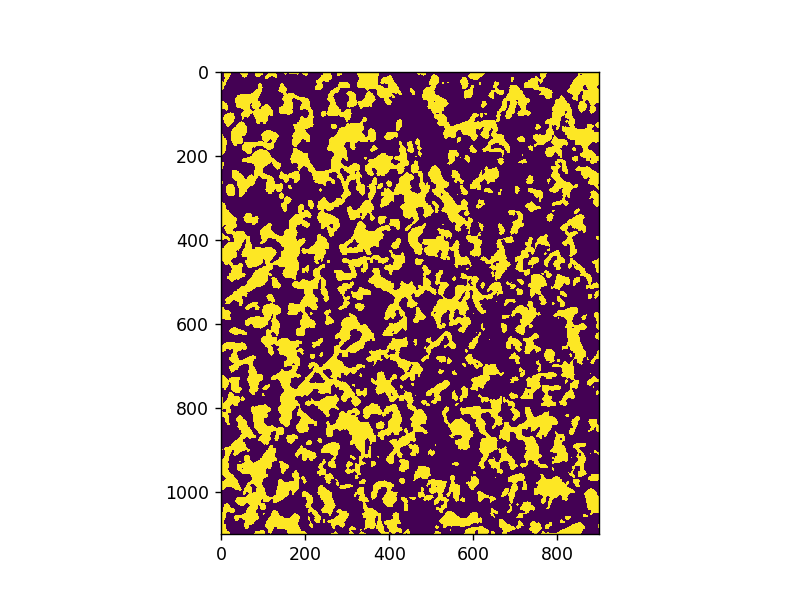

In [2]:
fig1 = plt.figure()
fig1.add_subplot()
filename = 'images/1984May9section1_SEG.png'
png_image=img.imread(filename)
plt.imshow(png_image)


## Auxiliary functions

For convenience several evaluation steps required below are provided as functions in the following cell. In a first step don't care about it, we will later come back to this cell and modify it where necessary. 
Execute the following cell.

In [3]:
def ice_indicator_function(image_filename):
    """
        read image and convert it to 1,0 indicator function
    """ 
    image=img.imread(image_filename)
    ice_indicator_function = np.asarray(image)
    return ice_indicator_function


def ice_volume_fraction(indicator_function):
    """
        compute ice volume fraction from an image indicator function
    """
    return np.mean(indicator_function)


def image_size(indicator_function):
    """
        get the size of the image
    """
    return indicator_function.shape    
  
    
        

def ACF1D(acf2d, axis):
    """
        extract the 1D correlation function along a given axis (0 or 1)
    """
    #slc = [slice(None)] * len(acf2d.shape)
    #slc[axis] = slice(0, acf2d.shape[axis])
    #return acf2d[slc]
    nz, nx = acf2d.shape
    if axis == 1:
        return acf2d[0,0:int((nx+1)/2)]
    elif axis == 0:
        return acf2d[0:int((nz+1)/2),0]
    else:
        return "stuss"
    
def acf1d_fit_exp(r, acf1d, r_max):
    """
        fit the correlation data acf1d for given lags r in the range [0,r_max] 
        to an exponential
        returns:
    """
    
    # set fitrange
    fitrange = (r < r_max)
    # define residual function for least squares fit
    def residual( p, r, acf ):
        C0 = p[0]
        correlation_length = p[1]
        return ( C0*np.exp( -r/correlation_length) - acf )

    # initial values for the optimization
    p0 = np.array([0.2,1e-3])

    # least square fit in the required range
    p_opt, info = opt.leastsq(residual, p0, args=(r[fitrange],acf1d[fitrange]))
    C0 = p_opt[0]
    correlation_length = p_opt[1]
    acf1d_exp = residual( p_opt, r, 0 )
    
    return acf1d_exp, [C0, correlation_length]


def acf1d_fit_ts(r, acf1d, r_max):
    """
        fit the correlation data acf1d for given lags r in the range [0,r_max] 
        to an exponential
    """
    
    # set fitrange
    fitrange = (r < r_max)
    # define residual function for least squares fit
    def residual( p, r, acf ):
        C0 = p[0]
        correlation_length = p[1]
        repeat_distance = p[2]
        return ( C0*np.exp( -r/correlation_length) * np.sinc(2*r/repeat_distance) - acf )

    # initial values for the optimization
    p0 = np.array([0.2,1e-3,1e-3])

    # least square fit in the required range
    p_opt, info = opt.leastsq(residual, p0, args=(r[fitrange],acf1d[fitrange]))
    C0 = p_opt[0]
    correlation_length = p_opt[1]
    repeat_distance = p_opt[2]
    acf1d_ts = residual( p_opt, r, 0 )
    return acf1d_ts, [C0, correlation_length, repeat_distance]


def ACF2D(indicator_function):
    """
        compute the 2D correlation function for the indicator_function of an image
    """

    ##################################################
    # replace the following by the correct code
    ##################################################
    return np.zeros_like(indicator_function)


def ssa_from_acf_slope(volume_fraction, acf_slope_at_origin):
    """
        compute the ssa from given slope of an autocorrelation function
        C(r) at the origin and the volume fraction.
        This relation is often called Debye relation
    """
    ##################################################
    # replace the following by the correct code
    ##################################################
    return 101010101010101010.2


# Task 1: Compute the correlation functions for the image

Execute the following cell. You will see a plot which gives nonsense.
Go back to the previous cell and implement the function `ACF2D` to compute the 2D autocorrelation function of the image (5 lines of code required). When finished, zoom into the image close to the origin and try to understand. 

[-1.8551303674818635e-18, 0.00099999999937744463]
[-1.8551303674818635e-18, 0.00099999999937744463]
[-2.2356059455008888e-18, 0.00099999999080904972, 0.0010000000007958467]
[-2.2356059455008888e-18, 0.00099999999080904972, 0.0010000000007958467]


<IPython.core.display.Javascript object>


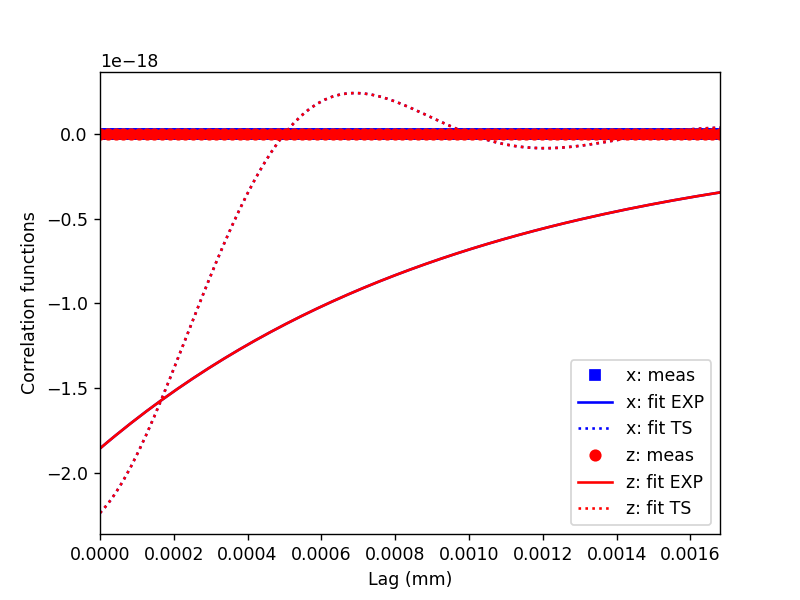

In [4]:
# get the ice indicator function for an example image
#
filename = 'images/1984May9section1_SEG.png'
pixel_size = 0.021e-3 # in mm

indicator_function = ice_indicator_function(filename)
# get the volume fraction
volume_fraction = ice_volume_fraction(indicator_function)
# ACTION REQUIRED HERE
# get the 2d correlation function
acf2d = ACF2D(indicator_function)


# get the 1d correlation function along an axis
acf1d_x = ACF1D(acf2d, 1)
acf1d_z = ACF1D(acf2d, 0)

# get the corresponding lags
r_x = pixel_size * np.arange(len(acf1d_x))
r_z = pixel_size * np.arange(len(acf1d_z))


# get the fit versions
r_max = 100 * pixel_size
acf1d_fit_exp_x, opt_param_exp_x = acf1d_fit_exp(r_x, acf1d_x, r_max)
print(opt_param_exp_x)
acf1d_fit_exp_z, opt_param_exp_z = acf1d_fit_exp(r_z, acf1d_z, r_max)
print(opt_param_exp_z)
acf1d_fit_ts_x, opt_param_ts_x = acf1d_fit_ts(r_x, acf1d_x, r_max)
print(opt_param_ts_x)
acf1d_fit_ts_z, opt_param_ts_z = acf1d_fit_ts(r_z, acf1d_z, r_max)
print(opt_param_ts_z)



# plot
fig2 = plt.figure()
ax2 = fig2.add_subplot(111)

ax2.plot(r_x, acf1d_x, 's', color='b', label='x: meas')
ax2.plot(r_x, acf1d_fit_exp_x, '-', color='b', label='x: fit EXP')
ax2.plot(r_x, acf1d_fit_ts_x, ':', color='b', label='x: fit TS')

ax2.plot(r_z, acf1d_z, 'o', color='r', label='z: meas')
ax2.plot(r_z, acf1d_fit_exp_z, '-', color='r', label='z: fit EXP')
ax2.plot(r_z, acf1d_fit_ts_z, ':', color='r', label='z: fit TS')

ax2.set_xlim([0, 80*pixel_size])
ax2.set_xlabel("Lag (mm)")
ax2.set_ylabel("Correlation functions")

ax2.legend()


# Task 2: SSA comparison

Now we have the correlation functions from a fit of the measured
data to an exponential model and to the Teubner-Strey model. The SSA of a microstructure
is related to the slope of the correlation function at the origin (cf lecture) and we can infer the SSA from the fit parameters and compare these.
Task: Implement the function `ssa_from_acf_slope` in the Auxiliary functions cell (one line of code required) and execute the following cell. Try to understand the differences.

In [5]:
### Check SSA



SSA_exp_x = ssa_from_acf_slope(volume_fraction, volume_fraction*(1-volume_fraction)/opt_param_exp_x[1])
SSA_exp_z = ssa_from_acf_slope(volume_fraction, volume_fraction*(1-volume_fraction)/opt_param_exp_z[1])
SSA_ts_x = ssa_from_acf_slope(volume_fraction, volume_fraction*(1-volume_fraction)/opt_param_ts_x[1])
SSA_ts_z = ssa_from_acf_slope(volume_fraction, volume_fraction*(1-volume_fraction)/opt_param_ts_z[1])


print("SSA from exponential fit in x direction: ", SSA_exp_x, "m^2/kg")
print("SSA from exponential fit in z direction: ", SSA_exp_z, "m^2/kg")
print("SSA from Teubner-Strey fit in x direction: ", SSA_ts_x, "m^2/kg")
print("SSA from Teubner-Strey fit in z direction: ", SSA_ts_z, "m^2/kg")



SSA from exponential fit in x direction:  1.0101010101010101e+17 m^2/kg
SSA from exponential fit in z direction:  1.0101010101010101e+17 m^2/kg
SSA from Teubner-Strey fit in x direction:  1.0101010101010101e+17 m^2/kg
SSA from Teubner-Strey fit in z direction:  1.0101010101010101e+17 m^2/kg


# Task 3: Brighness temperature comparison
Now we analyze how the different correlation functions influence the brightness temperature.
To this end we adapt the example from https://www.smrt-model.science/getstarted.html  
and use the derived parameters to compute the brightness temperature for a
homogeneous snowpack characterized by the respective correlation functions. This is a lazy task, nothing to implement. Try to understand the results.

In [6]:
# prepare inputs
thickness = [100]
temperature = [270]
density = volume_fraction * 917

# create an "exponential snowpack"
corr_length = opt_param_exp_x[1]
snowpack_exp = make_snowpack(thickness=thickness,
                             microstructure_model="exponential",
                             density=density,
                             temperature=temperature,
                             corr_length=corr_length)


# create a "Teubner-Strey snowpack"
corr_length = opt_param_ts_x[1]
repeat_distance = opt_param_ts_x[2]
snowpack_ts = make_snowpack(thickness=thickness,
                                 microstructure_model="teubner_strey",
                                 density=density,
                                 temperature=temperature,
                                 corr_length=corr_length,
                                 repeat_distance=repeat_distance)

# create the sensor
radiometer = sensor_list.amsre('37V')

# create the model
m = make_model("iba", "dort")

# run the model
result_exp = m.run(radiometer, snowpack_exp)
result_ts = m.run(radiometer, snowpack_ts)

# outputs
print("Brightness temperature (Exponential): ", result_exp.TbV(), "K")
print("Brightness temperature (Teubner Strey): ", result_ts.TbV(), "K")


Brightness temperature (Exponential):  92.8736203289236 K
Brightness temperature (Teubner Strey):  261.3623428435365 K


## Task 4: Play around

Here are some interesting suggestions what you may have a look at:
* Compare the value of the `repeat_distance` parameter with that of the `corr_length` paramters in the Teubner-Strey model
* Change the parameter `r_max` in the Task1 cell to `5*pixel_size` and check the impact on the SSA computation and the brightness temperature.


## Conclusion
Keep in mind: Microstructure details matter.